In [385]:
using JuMP, Gurobi
solver = optimizer_with_attributes(() -> Gurobi.Optimizer(), "OutputFlag" => 0, "Method" => 0)



MathOptInterface.OptimizerWithAttributes(var"#243#244"(), Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("OutputFlag") => 0, MathOptInterface.RawOptimizerAttribute("Method") => 0])

In [386]:
using JuMP,Gurobi ,GLPK, JSON,Pkg , Gurobi
model = Model(GLPK.Optimizer)
dict = Dict()
dict = JSON.parsefile("medium.json")


println("---weight--")
println(dict["weight"]["1"])
println("---From--")
println(dict["From"]["1"])
println("---To--")
println(dict["To"]["1"])
println(dict["t"])



---weight--
Dict{String, Any}("40" => 19, "6" => 8)
---From--
Any["6", "40"]
---To--
Any["27", "30"]
21


## Functions 

In [387]:
using LightGraphs
using GraphPlot
using Colors


function plotGraph(g , matrix, q, size,N_edge ,circular)

    membership=zeros(size)

    for i in 1:size
        for j in 1:size 
            membership[i] = membership[i]+q[j,i]
        end
    end
    membership = map(x -> x+1, (membership))
    membership = map(Int, membership)
    
    nodecolor = [colorant"lightgrey", colorant"orange"]
    nodefillc = nodecolor[membership]
    nodefillc[parse(Int,dict["s"])] = colorant"blue"
    colors = [colorant"lightgray" for i in  1:N_edge]

    index =1

    for i in 1:size 
        for j in 1:size
            if matrix[i,j] != 0
                if q[i,j] != 0
                    colors[index]= colorant"red"
                end
                index=index+1
            end
        end
    end
    if (circular == 1)
        gplot(g, nodefillc=nodefillc, edgestrokec=colors,layout=circular_layout)
    else
        gplot(g, nodefillc=nodefillc, edgestrokec=colors)
    end
end 

plotGraph (generic function with 3 methods)

In [388]:
size = length(dict["weight"])
matrix = zeros(size , size)

print(size)
for i in dict["N"]
    #display(dict["weight"][i])
end

50

In [389]:


#set_optimizer_attribute(model, "Presolve", 0)
#set_optimizer_attribute(model, "Heuristics",0)
#set_optimizer_attribute(model, "Cuts", 0)
size = length(dict["N"])
matrix = zeros(Int64,size , size)
b=zeros(size)
#print("\n")
b[parse(Int,dict["s"])] = 1
b[parse(Int,dict["t"])] = -1

color_vector = zeros(Int64 , size)

#print(matrix[10,:])
index = 1
amount = 0
for i in dict["N"]
    from = dict["From"][i]
    to = dict["To"][i]
    for j in from
        matrix[(parse(Int64,i)),parse(Int64,j)]=dict["weight"][i][j]
        amount = amount+1
    end
    color_vector[index] = amount 
    index = index+1 
end



In [390]:


n = size
a = zero(rand(n))

function create_master(model::Model)
    @variable(model, x[1:n, 1:n], Bin)
    
    a[parse(Int,dict["s"])] = 1
    a[parse(Int,dict["t"])] = -1
    for i in 1:size 
        for j in 1:size
            if matrix[i,j] == 0
                @constraint(model,x[i,j] == 0)
            end
        end
    end

    @constraint(model,[i=1:n],sum(x[i,j] -x[j,i] for j in 1:n) == a[i])
    
    @constraint(model,[i=1:n],sum(x[i,j] for j in 1:n) <= 1)
    
    @objective(model, Min, sum(sum( matrix[i,j] * x[i,j] for j in 1:n) for i in 1:n) ) #l'erreur dient d'ici
    
    
end

create_master (generic function with 1 method)

In [391]:
# empty model
master_model = Model(solver)

# empty model is initialized
create_master(master_model)

optimize!(master_model)
q = value.(master_model[:x])

#print(master_model)
solution_summary(master_model)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-04
Set parameter Method to value 0


* Solver : Gurobi

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution
  Objective value      : 4.20000e+01
  Objective bound      : 4.20000e+01
  Relative gap         : 0.00000e+00
  Dual objective value : 4.20000e+01

* Work counters
  Solve time (sec)   : 6.32811e-03
  Barrier iterations : 0
  Node count         : 1


In [392]:


using Graphs, Plots, GraphRecipes ,Colors  ,GraphPlot
g = Graphs.SimpleGraphs.SimpleDiGraph(size)


for i in 1:size 
    for j in 1:size
        if matrix[i,j] != 0
            Graphs.add_edge!(g, i, j)
            
        end
    end
end




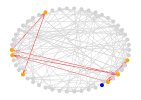

In [393]:
plotGraph(g ,matrix , q ,size , color_vector[size] , 1)
#plotGraph(g ,size , color_vector[size] , 0)

In [394]:
a = "s"
b = "aa"
print(a*b)

saa

## Dynamic Programming method

In [395]:
steps = 50

table = zeros(size , steps)
path_matrix = String[]
#initialisation

for i in 1:size
    push!(path_matrix, "")
end

for i in dict["From"][dict["s"]]
    table[parse(Int,i),1] = dict["weight"][dict["s"]][i]
    table[parse(Int,i),2] = dict["weight"][dict["s"]][i]
    path_matrix[parse(Int,i)] = dict["s"] *","*i
end


#continuation

for i in 2:steps 

    for a in 1:size
        table[a,i]=table[a,i-1]
    end
    for j in 1:size 
        
        if table[j , i-1] != 0
            
            for k in dict["From"][string(j)]
                if table[parse(Int,k) ,i] == 0
                    table[parse(Int,k) ,i] = table[j ,i-1] + dict["weight"][string(j)][k] 
                    path_matrix[parse(Int,k)] = path_matrix[j] * "," * k
                elseif table[parse(Int,k) ,i-1] > table[j ,i-1] + dict["weight"][string(j)][k] 
                    table[parse(Int,k) ,i] = table[j ,i-1] + dict["weight"][string(j)][k] 
                    path_matrix[parse(Int,k)] = path_matrix[j] * "," *k
                end
            end
        end
    end
end


display(table)
display(path_matrix)


print(table[parse(Int , dict["t"]),50])
print("\n")
print(path_matrix[parse(Int , dict["t"])])
print("\n")
print(dict["t"])
print(dict["s"])

50×50 Matrix{Float64}:
  0.0   0.0  21.0  21.0  21.0  21.0  …  21.0  21.0  21.0  21.0  21.0  21.0
  0.0   0.0   0.0   0.0  48.0  48.0     48.0  48.0  48.0  48.0  48.0  48.0
 14.0  14.0  14.0  14.0  14.0  14.0     14.0  14.0  14.0  14.0  14.0  14.0
  0.0   0.0   0.0   0.0  37.0  37.0     37.0  37.0  37.0  37.0  37.0  37.0
  0.0   0.0  25.0  25.0  25.0  25.0     25.0  25.0  25.0  25.0  25.0  25.0
  0.0   0.0  32.0  28.0  28.0  28.0  …  28.0  28.0  28.0  28.0  28.0  28.0
  0.0   0.0   0.0   0.0   0.0  65.0     65.0  65.0  65.0  65.0  65.0  65.0
  0.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
  0.0   0.0   0.0   0.0  57.0  55.0     51.0  51.0  51.0  51.0  51.0  51.0
  0.0   0.0   0.0   0.0   0.0   0.0     76.0  76.0  76.0  76.0  76.0  76.0
  ⋮                             ⋮    ⋱         ⋮                      
  0.0   0.0   0.0   0.0  46.0  38.0     38.0  38.0  38.0  38.0  38.0  38.0
  0.0  23.0  23.0  23.0  23.0  23.0     23.0  23.0  23.0  23.0  23.0  23.0
  0.0 

50-element Vector{String}:
 "9,3,30,1"
 "9,3,30,1,40,2"
 "9,3"
 "9,3,30,5,37,4"
 "9,3,30,5"
 "9,3,8,25,6"
 "9,3,30,1,40,2,7"
 "9,3,8"
 "9,3,8,25,6,26,50,9"
 "9,3,30,1,40,14,17,10"
 ⋮
 "9,20,43,48,11,42"
 "9,20,43"
 "9,3,30,1,40,44"
 "9,3,30,1,40,44,45"
 "9,3,8,46"
 "9,3,30,5,37,4,47"
 "9,20,43,48"
 "9,3,30,5,37,4,12,49"
 "9,3,8,25,6,26,50"

42.0
9,3,8,25,6,26,35,21
219

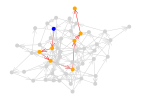

In [396]:
using Graphs, Plots, GraphRecipes ,Colors  ,GraphPlot
g = Graphs.SimpleGraphs.SimpleDiGraph(size)


string_list = collect(eachsplit(path_matrix[parse(Int , dict["t"])], ","))
q2 = zeros(size, size)
for i in 1:length(string_list)-1
    q2[parse(Int , string_list[i]), parse(Int , string_list[i+1])] =1
end

for i in 1:size 
    for j in 1:size
        if matrix[i,j] != 0
            Graphs.add_edge!(g, i, j)
        end
    end
end


plotGraph(g ,matrix , q2 ,size , color_vector[size] , 0)

